# Generate H5AD Input

In [2]:
# Import Packages

%load_ext autoreload
%autoreload 2

import os
# import warnings 
# warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from anndata import AnnData

# Customized packages
import starmap.sc_util as su

## AnnData

In [34]:
# Set path
ppath = 'Z:/Data/Processed/2022-10-15-Rena-SkinCulture254-gene/output'
areas = range(1,7)

In [35]:
# Load whole cell data
structure = 'whole_cell'
expr_path = os.path.join(ppath, structure, 'complete_cell_barcode_count.csv')
var_path = os.path.join(ppath, structure, 'cell_barcode_names.csv')
obs_path = os.path.join(ppath, structure, 'complete_meta.csv')

expr_x = np.loadtxt(expr_path, delimiter=',')
var = pd.read_csv(var_path, header=None)
var = pd.DataFrame(index=var.iloc[:,2].to_list())
obs = pd.read_csv(obs_path, index_col=0)

In [36]:
# create AnnData object
adata = AnnData(X=expr_x, dtype=int, var=var, obs=obs)
adata

c:\Users\wangk\.conda\envs\connie\lib\site-packages\anndata\_core\anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 12574 × 254
    obs: 'orig_index', 'sample', 'area', 'x', 'y', 'z'

In [37]:
# Load nucleus data
structure = 'nucleus'
expr_path = os.path.join(ppath, structure, 'complete_cell_barcode_count.csv')
var_path = os.path.join(ppath, structure, 'cell_barcode_names.csv')
obs_path = os.path.join(ppath, structure, 'complete_meta.csv')

# Add expression data to the AnnData object 
expr_x = np.loadtxt(expr_path, delimiter=',')
obs = pd.read_csv(obs_path, index_col=0)

adata.layers['nucleus'] = expr_x.astype(int)
adata.obs['nuclues_volume'] = obs['area'].values

In [38]:
adata.obs

,orig_index,sample,area,x,y,z,nuclues_volume
0,0,1,275680,63,6724,22,140797
1,1,1,280621,63,3816,18,46370
2,2,1,3402113,355,5604,24,313831
3,3,1,771134,121,9836,19,191065
4,4,1,1205013,146,5887,27,164774
...,...,...,...,...,...,...,...
12569,2072,6,862716,16595,12962,20,186196
12570,2073,6,326678,16667,7688,19,169223
12571,2074,6,309857,16658,10381,18,123123
12572,2075,6,290683,16646,8342,20,51620


In [39]:
# load AF546
p=0
for a in areas:
    af546 = pd.read_csv(os.path.join(ppath, '2022-11-07-merged-points', f'Area{a}', 'AF546_cell_counts.csv'))
    if not p:
        AF546 = af546
        p=1
    else: AF546 = pd.concat([AF546, af546], axis=0)
AF546

,whole_cell,nucleus
0,0,0
1,0,0
2,6,0
3,1,0
4,0,0
...,...,...
2072,0,0
2073,0,0
2074,1,0
2075,0,0


In [40]:
adata.obs['AF546'] = AF546['whole_cell'].values
adata.obs['AF546_nucleus'] = AF546['nucleus'].values
adata.obs

,orig_index,sample,area,x,y,z,nuclues_volume,AF546,AF546_nucleus
0,0,1,275680,63,6724,22,140797,0,0
1,1,1,280621,63,3816,18,46370,0,0
2,2,1,3402113,355,5604,24,313831,6,0
3,3,1,771134,121,9836,19,191065,1,0
4,4,1,1205013,146,5887,27,164774,0,0
...,...,...,...,...,...,...,...,...,...
12569,2072,6,862716,16595,12962,20,186196,0,0
12570,2073,6,326678,16667,7688,19,169223,0,0
12571,2074,6,309857,16658,10381,18,123123,1,0
12572,2075,6,290683,16646,8342,20,51620,0,0


## QC

c:\Users\wangk\.conda\envs\connie\lib\site-packages\scanpy\preprocessing\_normalization.py:182: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


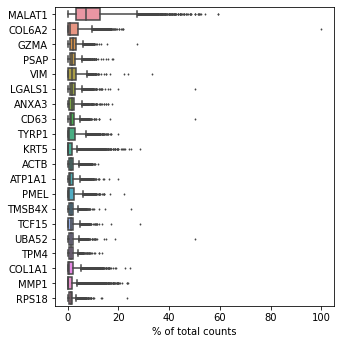

In [41]:
# Plot top 20 most expressed genes 
sc.pl.highest_expr_genes(adata, n_top=20)

## Regular Filtration

In [42]:
# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, percent_top=None, inplace=True)
# Calculate max count for each gene
adata.var['max_counts'] = adata.X.max(axis=0)

In [17]:
def plot_stats_per_cell(adata, color='sample', save=False):
    plt.figure(figsize=(15, 5))

    reads_per_cell = adata.obs['total_counts']
    genes_per_cell = adata.obs['n_genes_by_counts']

    plt.subplot(1, 3, 1)
    sns.histplot(reads_per_cell)
    plt.ylabel('# cells')
    plt.xlabel('# reads')

    plt.subplot(1, 3, 2)
    sns.histplot(genes_per_cell)
    plt.ylabel('# cells')
    plt.xlabel('# genes')

    plt.subplot(1, 3, 3)
    plt.title(
        'R=%f' % np.corrcoef(reads_per_cell.T, genes_per_cell)[0, 1])  # Pearson product-moment correlation coefficients
    sns.scatterplot(data=adata.obs, x='total_counts', y='n_genes_by_counts', hue=color, s=5)
    plt.xlabel("Reads per cell")
    plt.ylabel("Genes per cell")
    plt.legend(loc='lower right')
    plt.tight_layout()

    if save:
        # current_fig_path = os.path.join(os.getcwd(), "output/figures/cell_stats.pdf")
        current_fig_path = "./figures/cell_stats.pdf"
        plt.savefig(current_fig_path)
    plt.show()

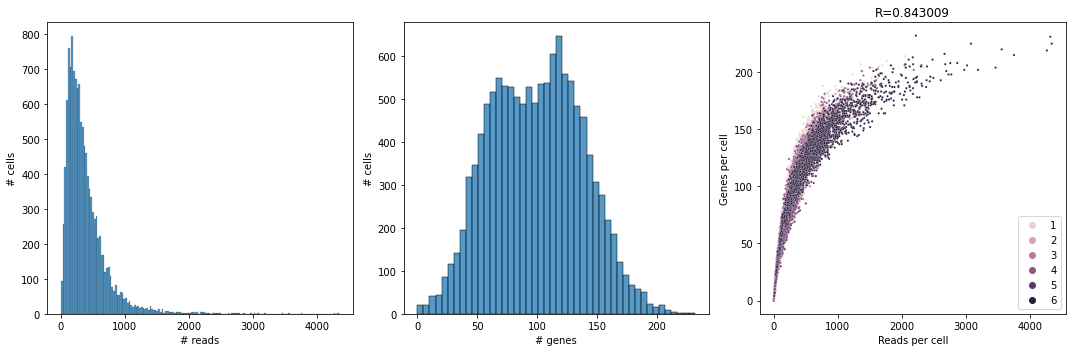

In [18]:
# Per-cell Stats Plot
plot_stats_per_cell(adata, save=False)

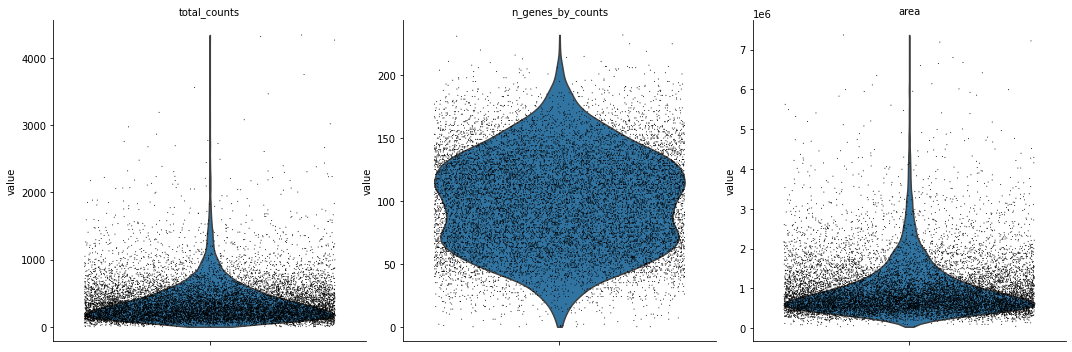

In [52]:
sc.pl.violin(adata, ['total_counts', 'n_genes_by_counts', 'area'],
             jitter=0.4, multi_panel=True)

In [53]:
# Get quantiles of reads
su.show_reads_quantile(adata)

Reads per cell quantile:
0.10    104.0
0.25    172.0
0.50    297.0
0.75    489.0
0.90    737.0
Name: total_counts, dtype: float64


## Output

In [44]:
area2sample = {
    1: '2h_labeling',
    2: '2h_labeling_2h_wash',
    3: '2h_labeling_4h_wash',
    4: '20h_labeling', 
    5: '2h_labeling_6h_wash', 
    6: 'STARmap'
}

In [45]:
sample_ = [area2sample[a] for a in adata.obs['sample']]
sample_

['2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_labeling',
 '2h_lab

In [46]:
adata.obs['plate_number'] = adata.obs['sample']
adata.obs['sample'] = sample_
adata.obs

,orig_index,sample,area,x,y,z,nuclues_volume,AF546,AF546_nucleus,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,plate_number
0,0,2h_labeling,275680,63,6724,22,140797,0,0,87,4.477337,146,4.990433,1
1,1,2h_labeling,280621,63,3816,18,46370,0,0,64,4.174387,121,4.804021,1
2,2,2h_labeling,3402113,355,5604,24,313831,6,0,128,4.859812,548,6.308098,1
3,3,2h_labeling,771134,121,9836,19,191065,1,0,142,4.962845,486,6.188264,1
4,4,2h_labeling,1205013,146,5887,27,164774,0,0,68,4.234107,141,4.955827,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12569,2072,STARmap,862716,16595,12962,20,186196,0,0,118,4.779123,476,6.167516,6
12570,2073,STARmap,326678,16667,7688,19,169223,0,0,84,4.442651,181,5.204007,6
12571,2074,STARmap,309857,16658,10381,18,123123,1,0,80,4.394449,174,5.164786,6
12572,2075,STARmap,290683,16646,8342,20,51620,0,0,81,4.406719,217,5.384495,6


In [47]:
from datetime import datetime
date = datetime.today().strftime('%Y-%m-%d')
adata.write_h5ad(os.path.join(ppath, '2022-11-12-Rena-Foreskin254gene-preflt.h5ad'))

c:\Users\wangk\.conda\envs\connie\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'sample' as categorical


In [48]:
# test
adata = sc.read_h5ad(os.path.join(ppath, '2022-11-12-Rena-Foreskin254gene-preflt.h5ad'))

In [49]:
adata

AnnData object with n_obs × n_vars = 12574 × 254
    obs: 'orig_index', 'sample', 'area', 'x', 'y', 'z', 'nuclues_volume', 'AF546', 'AF546_nucleus', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'plate_number'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts'
    layers: 'nucleus'

In [22]:
adata.X

array([[ 1,  1,  0, ...,  1,  0,  0],
       [ 0,  1,  0, ...,  3,  1,  0],
       [ 0,  3,  1, ...,  3,  0,  0],
       ...,
       [ 0,  5,  0, ...,  0,  0,  0],
       [ 0, 15,  0, ...,  0,  0,  0],
       [ 1, 45,  1, ...,  0,  2,  0]])

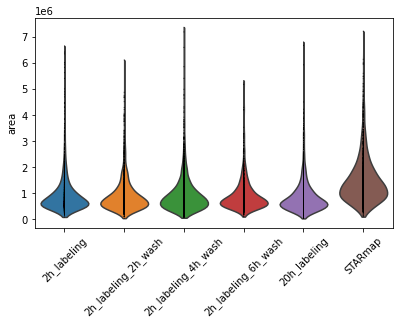

In [51]:
# cell volume
sc.pl.violin(adata, keys='area', groupby='sample', jitter=False, rotation=45)

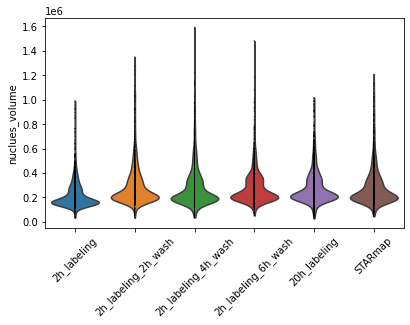

In [54]:
# nucleus volume
sc.pl.violin(adata, keys='nuclues_volume', groupby='sample', jitter=False, rotation=45)

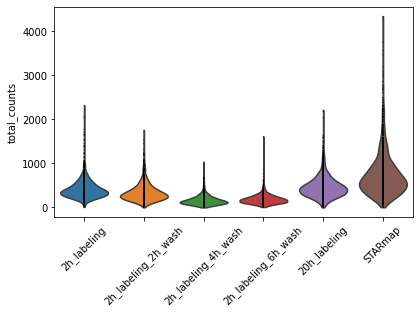

In [55]:
# total counts
sc.pl.violin(adata, keys='total_counts', groupby='sample', jitter=False, rotation=45)

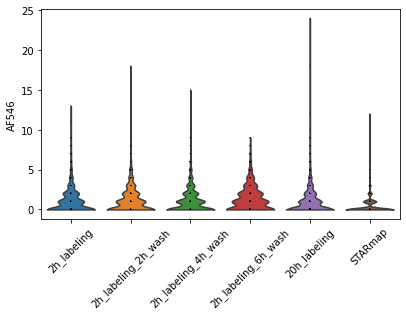

In [57]:
sc.pl.violin(adata, keys='AF546', groupby='sample', jitter=False, rotation=45)